# NESTML STDP windows tutorial

In this tutorial, we will plot the "window function", relating the weight change of a synapse to the relative timing of a single pair of pre- and postsynaptic spikes. This type of synaptic plasticity is commonly known as spike-timing depdendent plasticity (STDP).

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import re

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5.0-post0.dev0
 Built: Sep 14 2023 03:08:36

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Preliminaries

Experiments have shown that synaptic strength changes as a function of the precise spike timing of the presynaptic and postsynaptic neurons. If the pre neuron fires an action potential strictly before the post neuron, the synapse connecting them will be strengthened (“facilitated”). If the pre neuron fires after the post neuron, the synapse will be weakened (“depressed”). The depression and facilitation effects become stronger when the spikes occurred closer together in time. This is illustrated by empirical results (open circles), fitted by exponential curves (solid lines).

<!--
![image.png](attachment:image.png)
-->
<div>
<img src="attachment:image.png" width="500">
</div>

*Asymmetric STDP learning window. Spike-timing window of STDP for the induction of synaptic potentiation and depression characterized in hippocampal cultures. Data points from Bi and Poo (1998) [18], represent the relative change in the amplitude of EPSC after repetitive correlated activity of pre-post spike pairs. The LTP (+) and LTD (-) windows are fitted by the exponential function ∆g = A ± exp(−|∆t|/τ), with parameters A + = 0.86, A − = −0.25, τ + = 19 ms, and τ − = 34 ms. Adopted from Bi and Wang (2002).*

We will define the theoretical model following [3]_.

A pair of spikes in the input and the output cell, at times $t_i$ and $t_j$ respectively, induces a change $\Delta w$ in the weight $w$:

\begin{equation}
\Delta^\pm w = \pm \lambda \cdot f_\pm(w) \cdot K(|t_o - t_i|)
\end{equation}

The weight is increased by $\Delta^+ w$ when $t_o>t_i$ and decreased by $\Delta^- w$ when $t_i>t_o$. The temporal dependence of the update is defined by the filter kernel $K$ which is taken to be $K(t) = \exp(-t/\tau)$. The coefficient $\lambda\in\mathbb{R}$ sets the magnitude of the update. The functions $f_\pm(w)$ determine the relative magnitude of the changes in the positive and negative direction. These are here taken as

\begin{align}
f_+(w) &= (1 - w)^{\mu_+}\\
f_-(w) &= \alpha w^{\mu_-}
\end{align}

with the parameter $\alpha\in\mathbb{R}, \alpha>0$ allowing to set an asymmetry between increasing and decreasing the synaptic efficacy, and $\mu_\pm\in\{0,1\}$ allowing to choose between four different kinds of STDP (for references, see https://nest-simulator.readthedocs.io/en/nest-2.20.1/models/stdp.html?highlight=stdp#_CPPv4I0EN4nest14STDPConnectionE).

To implement the kernel, we use two extra state variables to keep track of recent spiking activity. These could correspond to calcium concentration in biology. One presynaptic trace value and another postsynaptic trace value is used, for pre- and post spiking, respectively. These maintain a history of neuron spikes, being incremented by 1 whenever a spike is generated, and decaying back to zero exponentially; in other words, a convolution between the exponentially decaying kernel and the emitted spike train:

\begin{equation}
\text{tr\_pre} = K \ast \sum_i \delta_{pre,i}
\end{equation}

and

\begin{equation}
\text{tr\_post} = K \ast \sum_i \delta_{post,i}
\end{equation}

These are implemented in the NESTML model as follows:

```
equations:
    # all-to-all trace of presynaptic neuron
    kernel pre_tr_kernel = exp(-t / tau_tr_pre)
    inline pre_tr real = convolve(pre_tr_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_tr_kernel = exp(-t / tau_tr_post)
    inline post_tr real = convolve(post_tr_kernel, post_spikes)
```

with time constants defined as parameters:

```
parameters:
    tau_tr_pre ms = 20 ms
    tau_tr_post ms = 20 ms
```

With the traces in place, the weight updates can then be expressed closely following the mathematical definitions.

Begin by defining the weight and its initial value:

```
state:
    w real = 1.
```

The update rule for facilitation:

\begin{equation}
\Delta^+ w = \lambda \cdot (1 - w)^{\mu+} \cdot \text{pre\_trace}
\end{equation}

In NESTML, this rule is written in the `onReceive` event handler block. Statements in this block will be executed when the event occurs: in this case, receiving a presynaptic spike. In NESTML, additional scaling with an absolute maximum weight ``Wmax`` is added.

```
onReceive(post_spikes):
    # potentiate synapse
    w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
    w = min(Wmax, w_)
```

The update rule for depression :

\begin{equation}
\Delta^- w = -\alpha \cdot \lambda \cdot w^{\mu_-} \cdot \text{post\_trace}
\end{equation}

```
onReceive(pre_spikes):
    # depress synapse
    w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
    w = max(Wmin, w_)

    # deliver spike to postsynaptic partner
    deliver_spike(w, d)
```

Finally, the remaining parameters are defined:

```
parameters:
    lambda real = .01
    alpha real = 1.
    mu_plus real = 1.
    mu_minus real = 1.
    Wmax real = 100.
    Wmin real = 0.
```


## Generating code with NESTML

### Formulating the model in NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion.

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential, the "iaf_psc_delta" model.

We now define a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. The resulting model names are composed of associated neuron and synapse partners, because of the co-generation, for example, "stdp_synapse__with_iaf_psc_delta" and "iaf_psc_delta__with_stdp_synapse".

Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "stdp_synapse0__with_iaf_psc_delta0" and "iaf_psc_delta0__with_stdp_synapse0".

The resulting neuron and synapse model names are returned by the function, so we do not have to think about these internals.

We now go on to define the full synapse model in NESTML:

In [2]:
nestml_stdp_model = """
synapse stdp:

    state:
        w real = 1.  @nest::weight

    parameters:
        d ms = 1 ms  @nest::delay
        lambda real = .01
        tau_tr_pre ms = 20 ms
        tau_tr_post ms = 20 ms
        alpha real = 1
        mu_plus real = 1
        mu_minus real = 1
        Wmax real = 100.
        Wmin real = 0.

    equations:
        kernel pre_trace_kernel = exp(-t / tau_tr_pre)
        inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

        # all-to-all trace of postsynaptic neuron
        kernel post_trace_kernel = exp(-t / tau_tr_post)
        inline post_trace real = convolve(post_trace_kernel, post_spikes)

    input:
        pre_spikes <- spike
        post_spikes <- spike

    output:
        spike

    onReceive(post_spikes):
        # potentiate synapse
        w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
        w = min(Wmax, w_)

    onReceive(pre_spikes):
        # depress synapse
        w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
        w = max(Wmin, w_)

        # deliver spike to postsynaptic partner
        deliver_spike(w, d)
"""

Generate the code, build the user module and make the model available to instantiate in NEST:

In [3]:
module_name, neuron_model_name, synapse_model_name = NESTCodeGeneratorUtils.generate_code_for(
    "../../../models/neurons/iaf_psc_delta.nestml",
    nestml_stdp_model,
    post_ports=["post_spikes"])

nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5.0-post0.dev0
 Built: Sep 14 2023 03:08:36

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
[12,iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml, WARNING, [59:8;60:8]]: Variable 'G' has the same name as a physical unit!
[13,iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml, WARNING, [77:8;77:26]]: Variable 'h' has the same name as a physical unit!
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
[18,stdpb615d5947f594eab8d9b7f37cb0cd640_nestml, WARNING, [8:8;8:28]]: Variable 'd' has the same name as a physical unit!
[23,iaf_psc_

/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml__with_stdpb615d5947f594eab8d9b7f37cb0cd640_nestml.cpp: In constructor ‘iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml__with_stdpb615d5947f594eab8d9b7f37cb0cd640_nestml::iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml__with_stdpb615d5947f594eab8d9b7f37cb0cd640_nestml()’:
/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml__with_stdpb615d5947f594eab8d9b7f37cb0cd640_nestml.cpp:105:16: warning: unused variable ‘__resolution’ [-Wunused-variable]
  105 |   const double __resolution = nest::Time::get_resolution().get_ms();  // do not remove, this is necessary for the resolution() function
      |                ^~~~~~~~~~~~
/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml__with_stdpb615d5947f594eab

/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/stdpb615d5947f594eab8d9b7f37cb0cd640_nestml__with_iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml.h: In instantiation of ‘void nest::stdpb615d5947f594eab8d9b7f37cb0cd640_nestml__with_iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml<targetidentifierT>::send(nest::Event&, size_t, const nest::stdpb615d5947f594eab8d9b7f37cb0cd640_nestml__with_iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestmlCommonSynapseProperties&) [with targetidentifierT = nest::TargetIdentifierPtrRport; size_t = long unsigned int]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_base.h:381:22:   required from ‘void nest::Connector<ConnectionT>::send_to_all(size_t, const std::vector<nest::ConnectorModel*>&, nest::Event&) [with ConnectionT = nest::stdpb615d5947f594eab8d9b7f37cb0cd640_nestml__with_iaf_psc_deltab615d5947f594eab8d9b7f37cb0cd640_nestml<nest::TargetIdentifierPtrRport>; size_t = long unsigned int]’
/home/c

[100%] Linking CXX shared module nestml_b615d5947f594eab8d9b7f37cb0cd640_module.so
[100%] Built target nestml_b615d5947f594eab8d9b7f37cb0cd640_module_module
[100%] Built target nestml_b615d5947f594eab8d9b7f37cb0cd640_module_module
Install the project...
-- Install configuration: ""
-- Installing: /home/charl/julich/nest-simulator-install/lib/nest/nestml_b615d5947f594eab8d9b7f37cb0cd640_module.so

Sep 15 05:21:35 Install [Info]: 
    loaded module nestml_b615d5947f594eab8d9b7f37cb0cd640_module


### Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell and one postsynaptic cell connected by a single synapse, then run a simulation and plot the results.

In [4]:
def run_network(pre_spike_time, post_spike_time,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=1., # [ms]
                          delay=1., # [ms]
                          lmbda=1E-6,
                          sim_time=None,  # if None, computed from pre and post spike times
                          synapse_parameters=None,  # optional dictionary passed to the synapse
                          fname_snip=""):

    nest.set_verbosity("M_WARNING")
    #nest.set_verbosity("M_ALL")

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})

    wr = nest.Create('weight_recorder')
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                {"weight_recorder": wr[0],
                 "weight": 1.,
                 "delay": delay,
                 "receptor_type": 0,
                 "mu_minus": 0.,
                 "mu_plus": 0.})

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                         params={"spike_times": [pre_spike_time, sim_time - 10.]})
    post_sg = nest.Create("spike_generator",
                          params={"spike_times": [post_spike_time],
                                  'allow_offgrid_times': True})

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)

    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    #mm = nest.Create("multimeter", params={"record_from" : ["V_m"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1., "weight": 9999.})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={'synapse_model': 'stdp_nestml_rec'})
    #nest.Connect(mm, post_neuron)

    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)

    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")
    if synapse_parameters is None:
        synapse_parameters = {}
    synapse_parameters.update({"lambda": lmbda})
    nest.SetStatus(syn, synapse_parameters)

    initial_weight = nest.GetStatus(syn)[0]["weight"]
    np.testing.assert_allclose(initial_weight, 1)
    nest.Simulate(sim_time)
    updated_weight = nest.GetStatus(syn)[0]["weight"]

    actual_t_pre_sp = nest.GetStatus(spikedet_pre)[0]["events"]["times"][0]
    actual_t_post_sp = nest.GetStatus(spikedet_post)[0]["events"]["times"][0]

    dt = actual_t_post_sp - actual_t_pre_sp
    dw = (updated_weight - initial_weight) / lmbda

    return dt, dw

Then, we can run the experiment. We set the pre spike time to a constant (100 ms) and loop over values for the post spike time (25 to 175 ms).

Note that the dendritic delay in this example has been set to 10 ms, to make its effect on the STDP window more clear: it is not centered around zero, but shifted to the left by the dendritic delay. Hint: play with the parameters a bit here and see the effects it has on the returned window.

In [5]:
def stdp_window(neuron_model_name, synapse_model_name, synapse_parameters=None):
    sim_time = 1000.  # [ms]
    pre_spike_time = 100. #sim_time / 2  # [ms]
    delay = 10. # dendritic delay [ms]

    dt_vec = []
    dw_vec = []
    for post_spike_time in np.arange(25, 175).astype(float):
        dt, dw = run_network(pre_spike_time, post_spike_time,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=1., # [ms]
                          delay=delay, # [ms]
                          synapse_parameters=synapse_parameters,
                          sim_time=sim_time)
        dt_vec.append(dt)
        dw_vec.append(dw)
        
    return dt_vec, dw_vec, delay

In [6]:
def plot_stdp_window(dt_vec, dw_vec, delay):
    fig, ax = plt.subplots(dpi=120)
    ax.scatter(dt_vec, dw_vec)
    ax.set_xlabel(r"t_post - t_pre [ms]")
    ax.set_ylabel(r"$\Delta w$")

    for _ax in [ax]:
        _ax.grid(which="major", axis="both")
        _ax.grid(which="minor", axis="x", linestyle=":", alpha=.4)
        _ax.set_xlim(np.amin(dt_vec), np.amax(dt_vec))
        #_ax.minorticks_on()
        #_ax.set_xlim(0., sim_time)

    ylim = ax.get_ylim()
    ax.plot((np.amin(dt_vec), np.amax(dt_vec)), (0, 0), linestyle="--", color="black", linewidth=2, alpha=.5)
    ax.plot((-delay, -delay), ylim, linestyle="--", color="black", linewidth=2, alpha=.5)
    ax.set_ylim(ylim)

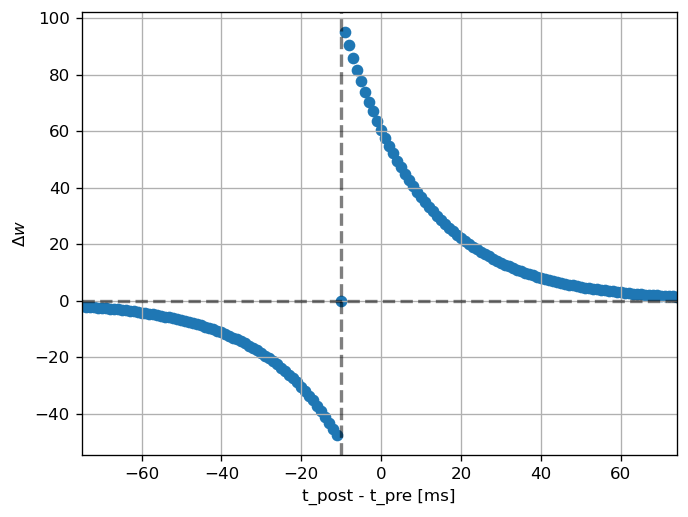

In [7]:
dt_vec, dw_vec, delay = stdp_window(neuron_model_name, synapse_model_name,
                                    synapse_parameters={"alpha": .5})

plot_stdp_window(dt_vec, dw_vec, delay)

Symmetric LTP or LTD-only
----------------------

Depending on the frequency at which the spike pairing protocol is repeated, a symmetric potentiation-only window can occur for high repetition rates, whereas for low rates, a depression-only window is observed.

Facilitation-only is easy to obtain without even changing the model:

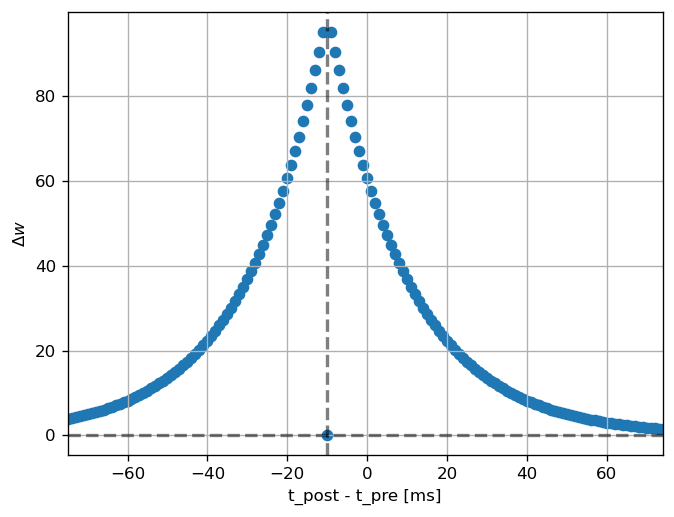

In [8]:
dt_vec, dw_vec, delay = stdp_window(neuron_model_name, synapse_model_name,
                                    synapse_parameters={"alpha": -1.})
plot_stdp_window(dt_vec, dw_vec, delay)

Adapt the model to obtain the symmetric depression-only window.

Windowed STDP
------------

In this variant of the original STDP rule, we allow only spikes more than a few milliseconds apart to cause the weight to change. If the pre-post absolute $|\Delta t|$ is smaller than some threshold, the weight change should be zero.

In [9]:
nestml_windowed_stdp_model = """
synapse stdp_windowed:

    state:
        w real = 1.  @nest::weight
        pre_nn_trace real = 0.
        post_nn_trace real = 0.

    parameters:
        d ms = 1 ms  @nest::delay
        lambda real = .01
        tau_tr_pre ms = 20 ms
        tau_tr_post ms = 20 ms
        alpha real = 1
        mu_plus real = 1
        mu_minus real = 1
        Wmax real = 100.
        Wmin real = 0.
        tau_recency_window_pre ms = 10 ms
        tau_recency_window_post ms = 10 ms

    equations:
        kernel pre_trace_kernel = exp(-t / tau_tr_pre)
        inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

        # all-to-all trace of postsynaptic neuron
        kernel post_trace_kernel = exp(-t / tau_tr_post)
        inline post_trace real = convolve(post_trace_kernel, post_spikes)

        pre_nn_trace' = -pre_nn_trace / tau_recency_window_pre
        post_nn_trace' = -post_nn_trace / tau_recency_window_post

    input:
        pre_spikes <- spike
        post_spikes <- spike

    output:
        spike

    onReceive(post_spikes):
        post_nn_trace = 1

        if pre_nn_trace < .7:
            # potentiate synapse
            w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
            w = min(Wmax, w_)

    onReceive(pre_spikes):
        pre_nn_trace = 1

        if post_nn_trace < .7:
            # depress synapse
            w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
            w = max(Wmin, w_)

        # deliver spike to postsynaptic partner
        deliver_spike(w, d)
"""

In [10]:
module_name, neuron_model_name, synapse_model_name = NESTCodeGeneratorUtils.generate_code_for(
    "../../../models/neurons/iaf_psc_delta.nestml",
    nestml_windowed_stdp_model,
    post_ports=["post_spikes"])
nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5.0-post0.dev0
 Built: Sep 14 2023 03:08:36

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
[12,iaf_psc_delta70b1de556ba345bbbf3190dd5bd52d28_nestml, WARNING, [59:8;60:8]]: Variable 'G' has the same name as a physical unit!
[13,iaf_psc_delta70b1de556ba345bbbf3190dd5bd52d28_nestml, WARNING, [77:8;77:26]]: Variable 'h' has the same name as a physical unit!
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
[18,stdp_windowed70b1de556ba345bbbf3190dd5bd52d28_nestml, WARNING, [10:8;10:28]]: Variable 'd' has the same name as a physical unit!
[

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
CMake Warning:
  Ignoring empty string ("") provided on the command line.


CMake Warning (dev) at CMakeLists.txt:95 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_70b1de556ba345bbbf3190dd5bd52d28_module Configu

/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/stdp_windowed70b1de556ba345bbbf3190dd5bd52d28_nestml__with_iaf_psc_delta70b1de556ba345bbbf3190dd5bd52d28_nestml.h: In instantiation of ‘void nest::stdp_windowed70b1de556ba345bbbf3190dd5bd52d28_nestml__with_iaf_psc_delta70b1de556ba345bbbf3190dd5bd52d28_nestml<targetidentifierT>::send(nest::Event&, size_t, const nest::stdp_windowed70b1de556ba345bbbf3190dd5bd52d28_nestml__with_iaf_psc_delta70b1de556ba345bbbf3190dd5bd52d28_nestmlCommonSynapseProperties&) [with targetidentifierT = nest::TargetIdentifierPtrRport; size_t = long unsigned int]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_base.h:381:22:   required from ‘void nest::Connector<ConnectionT>::send_to_all(size_t, const std::vector<nest::ConnectorModel*>&, nest::Event&) [with ConnectionT = nest::stdp_windowed70b1de556ba345bbbf3190dd5bd52d28_nestml__with_iaf_psc_delta70b1de556ba345bbbf3190dd5bd52d28_nestml<nest::TargetIdentifierPtrRport>; 

[100%] Linking CXX shared module nestml_70b1de556ba345bbbf3190dd5bd52d28_module.so
[100%] Built target nestml_70b1de556ba345bbbf3190dd5bd52d28_module_module
[100%] Built target nestml_70b1de556ba345bbbf3190dd5bd52d28_module_module
Install the project...
-- Install configuration: ""
-- Installing: /home/charl/julich/nest-simulator-install/lib/nest/nestml_70b1de556ba345bbbf3190dd5bd52d28_module.so


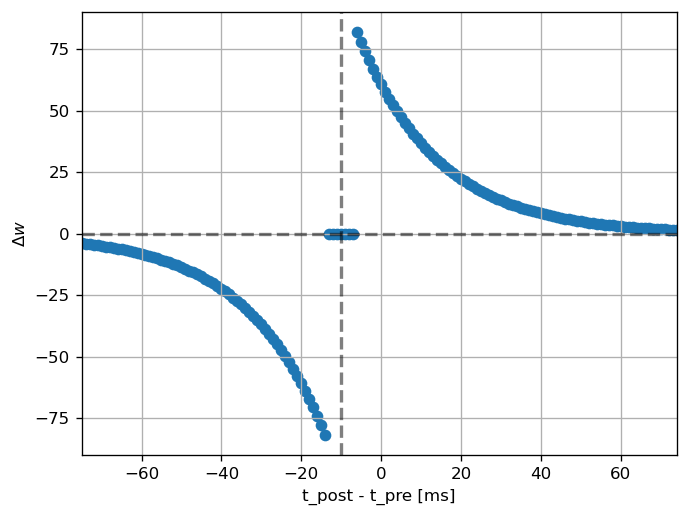

In [11]:
dt_vec, dw_vec, delay = stdp_window(neuron_model_name, synapse_model_name)
plot_stdp_window(dt_vec, dw_vec, delay)

Symmetric inhibitory STDP
--------------------

<!--
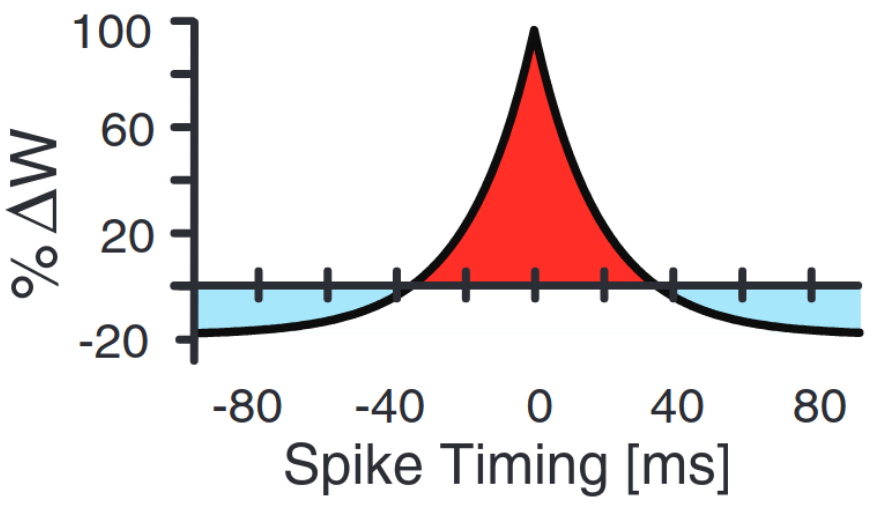
-->
<div>
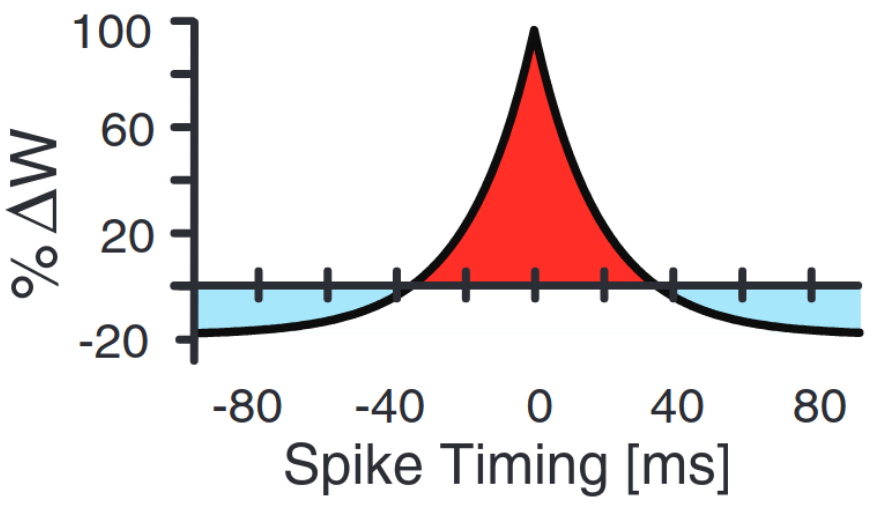
</div>

The symmetric STDP window in the figure can be observed experimentally and was used to achieve a self-organised balance between excitation and inhibition in recurrent networks [4]_.

In [12]:
nestml_stdp_vogels_model = """
synapse stdp_vogels:

    state:
        w real = 1.  @nest::weight

    parameters:
        d ms = 1 ms  @nest::delay
        lambda real = .01
        offset real = 1.
        tau_tr_pre ms = 20 ms
        tau_tr_post ms = 20 ms
        alpha real = 1
        mu_plus real = 1
        mu_minus real = 1
        Wmax real = 100.
        Wmin real = 0.

    equations:
        kernel pre_trace_kernel = exp(-t / tau_tr_pre)
        inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

        # all-to-all trace of postsynaptic neuron
        kernel post_trace_kernel = exp(-t / tau_tr_post)
        inline post_trace real = convolve(post_trace_kernel, post_spikes)

    input:
        pre_spikes <- spike
        post_spikes <- spike

    output:
        spike

    onReceive(post_spikes):
        w += lambda * (pre_trace + post_trace)

    onReceive(pre_spikes):
        w += lambda * (pre_trace + post_trace - offset)

        # deliver spike to postsynaptic partner
        deliver_spike(w, d)
"""

Save to a temporary file and make the model available to instantiate in NEST:

In [13]:
module_name, neuron_model_name, synapse_model_name = NESTCodeGeneratorUtils.generate_code_for(
    "../../../models/neurons/iaf_psc_delta.nestml",
    nestml_stdp_vogels_model,
    post_ports=["post_spikes"])
nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5.0-post0.dev0
 Built: Sep 14 2023 03:08:36

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
[12,iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml, WARNING, [59:8;60:8]]: Variable 'G' has the same name as a physical unit!
[13,iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml, WARNING, [77:8;77:26]]: Variable 'h' has the same name as a physical unit!
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10
[18,stdp_vogels237b5be8336a4c6f93542bca3ddf7506_nestml, WARNING, [8:8;8:28]]: Variable 'd' has the same name as a physical unit!
[23,i

/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml.cpp: In constructor ‘iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml::iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml()’:
/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml.cpp:104:16: warning: unused variable ‘__resolution’ [-Wunused-variable]
  104 |   const double __resolution = nest::Time::get_resolution().get_ms();  // do not remove, this is necessary for the resolution() function
      |                ^~~~~~~~~~~~
/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml.cpp: In member function ‘virtual void iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml::update(const nest::Time&, long int, long int)’:
/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/iaf_psc_d

/home/charl/julich/nestml-upstream2/nestml/doc/tutorials/stdp_windows/target/stdp_vogels237b5be8336a4c6f93542bca3ddf7506_nestml__with_iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml.h: In instantiation of ‘void nest::stdp_vogels237b5be8336a4c6f93542bca3ddf7506_nestml__with_iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml<targetidentifierT>::send(nest::Event&, size_t, const nest::stdp_vogels237b5be8336a4c6f93542bca3ddf7506_nestml__with_iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestmlCommonSynapseProperties&) [with targetidentifierT = nest::TargetIdentifierPtrRport; size_t = long unsigned int]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_base.h:381:22:   required from ‘void nest::Connector<ConnectionT>::send_to_all(size_t, const std::vector<nest::ConnectorModel*>&, nest::Event&) [with ConnectionT = nest::stdp_vogels237b5be8336a4c6f93542bca3ddf7506_nestml__with_iaf_psc_delta237b5be8336a4c6f93542bca3ddf7506_nestml<nest::TargetIdentifierPtrRport>; size_t =

[100%] Linking CXX shared module nestml_237b5be8336a4c6f93542bca3ddf7506_module.so
[100%] Built target nestml_237b5be8336a4c6f93542bca3ddf7506_module_module
[100%] Built target nestml_237b5be8336a4c6f93542bca3ddf7506_module_module
Install the project...
-- Install configuration: ""
-- Installing: /home/charl/julich/nest-simulator-install/lib/nest/nestml_237b5be8336a4c6f93542bca3ddf7506_module.so


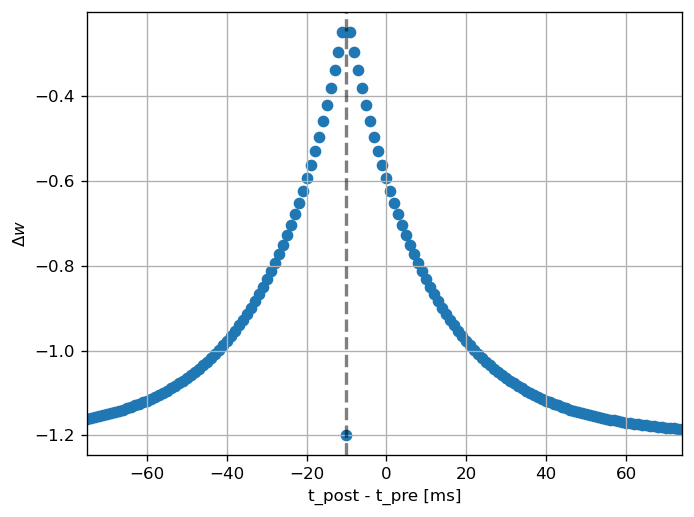

In [14]:
dt_vec, dw_vec, delay = stdp_window(neuron_model_name,
                                    synapse_model_name,
                                    synapse_parameters={"offset": .6})
plot_stdp_window(dt_vec, dw_vec, delay)

Further directions
---------------------
  
* **Bursting dependent rules**

  Neuronal bursting is when action potentials are fired at high frequency in groups, separated by periods of quiescence. Bursting can be considered a different communication signal from the normal firing of action potentials. Search for (or come up with) a burst-dependent learning rule, and implement it in NESTML.

  <p>&nbsp;</p>
  
* **Triplet relationships**

  So far, we have looked at the relative timing of two spikes, $\Delta t$ on the horizontal axis.

  Come up with a triplet spike protocol, that involves not just the time difference between two but between three spikes. Make a 3D plot of $\Delta w$ as a function of the timing parameters $\Delta t_1$ and $\Delta t_2$. What do you expect to see?

  <p>&nbsp;</p>

* **Multiphasic windows**
  
  Patch clamping is a common recording technique that uses a micropipette filled with a liquid that mimics the intracellular environment. When cesium ions (Cs<sup>+</sup>) are introduced into this solution, an extra potentiation window is seen for long pre-after-post delays. This thought to be caused by cesium blocking of potassium channels, which depolarises the postsynaptic neuron, and enhance and lengthen backpropagating action potentials in the apical dendrite [I]_.

  <!--
  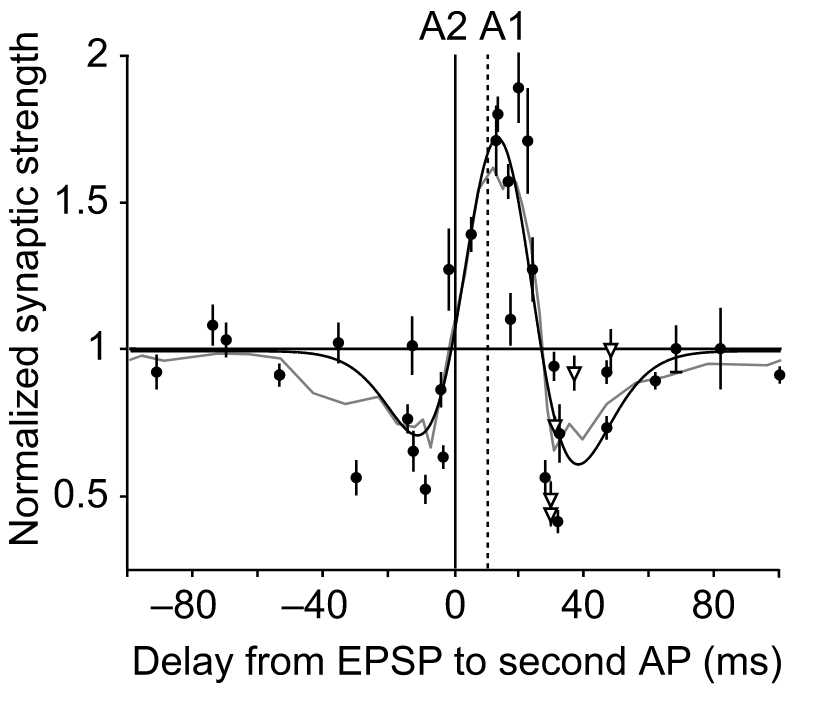
  -->
  <div>
  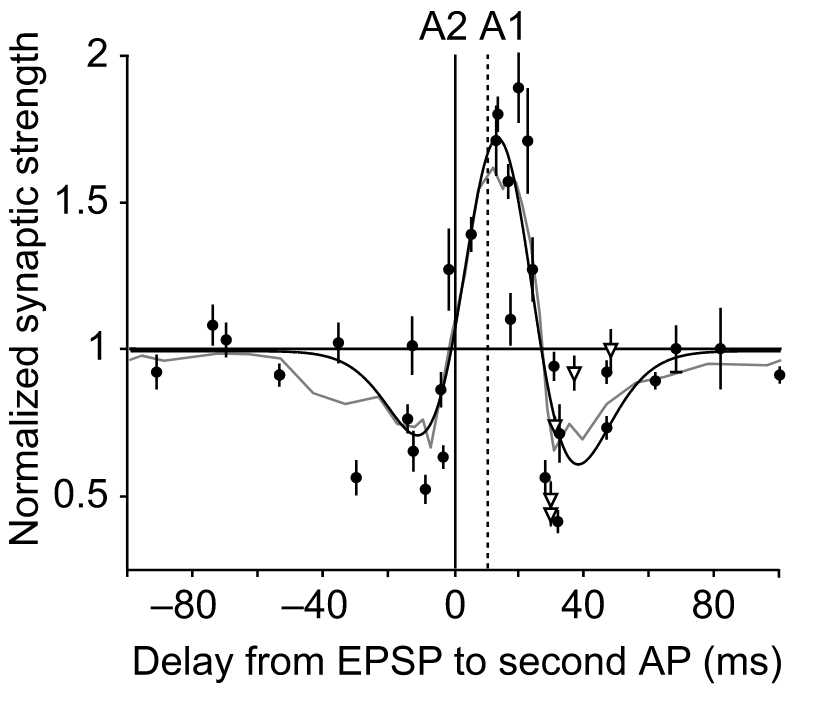
  </div>

  In the figure, the data is fit with a difference-of-gaussians curve (continuous black line). It could be easier to approach this using the existing exponentially decaying trace values, but add an additional trace with higher-order dynamics (where the exponentially decaying function has order 1).
  
  [I] Malleability of Spike-Timing-Dependent Plasticity at the CA3–CA1 Synapse
  Gayle M. Wittenberg, Samuel S.-H. Wang
  Journal of Neuroscience 14 June 2006, 26 (24) 6610-6617

References
----------

[1] Morrison A., Diesmann M., and Gerstner W. (2008) Phenomenological models of synaptic plasticity based on spike timing, Biol. Cybern. 98, 459–478 https://doi.org/10.1007/s00422-008-0233-1

[2] Front. Comput. Neurosci., 23 November 2010 Enabling functional neural circuit simulations with distributed computing of neuromodulated plasticity, Wiebke Potjans, Abigail Morrison and Markus Diesmann https://doi.org/10.3389/fncom.2010.00141 

[3] Rubin, Lee and Sompolinsky. Equilibrium Properties of Temporally Asymmetric Hebbian Plasticity. Physical Review Letters, 8 Jan 2001, Vol 86, No 2 http://doi.org/10.1103/PhysRevLett.86.364

[4] Vogels, Sprekeler, Zenke, Clopath and Gerstner (2011). Inhibitory Plasticity Balances Excitation and Inhibition in Sensory Pathways and Memory Networks. Science Vol 334 https://doi.org/10.1126/science.1211095 

Acknowledgements
----------------

The authors thank Younes Bouhadjar for his suggestions on use cases and valuable feedback.

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.